In [1]:
# 混凝土裂缝识别

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [4]:
positive_dir = Path(r"E:\download\surface-crack-detection\Positive")
negative_dir = Path(r"E:\download\surface-crack-detection\Negative")

In [5]:
# Create DadaFrames
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [6]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,E:\download\surface-crack-detection\Positive\0...,POSITIVE
1,E:\download\surface-crack-detection\Positive\1...,POSITIVE
2,E:\download\surface-crack-detection\Positive\1...,POSITIVE
3,E:\download\surface-crack-detection\Negative\1...,NEGATIVE
4,E:\download\surface-crack-detection\Positive\0...,POSITIVE
...,...,...
39995,E:\download\surface-crack-detection\Positive\0...,POSITIVE
39996,E:\download\surface-crack-detection\Negative\1...,NEGATIVE
39997,E:\download\surface-crack-detection\Positive\0...,POSITIVE
39998,E:\download\surface-crack-detection\Positive\1...,POSITIVE


In [7]:
train_df, test_df = train_test_split(
    all_df.sample(1000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [8]:
# Load Data
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [9]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 560 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [10]:
# Train
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 118, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33    

In [11]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
18/18 [==============================] - 2s 87ms/step - loss: 0.6926 - accuracy: 0.5536 - val_loss: 0.6879 - val_accuracy: 0.5286
Epoch 2/50
18/18 [==============================] - 1s 80ms/step - loss: 0.6857 - accuracy: 0.5429 - val_loss: 0.6808 - val_accuracy: 0.6500
Epoch 3/50
18/18 [==============================] - 1s 81ms/step - loss: 0.6798 - accuracy: 0.5857 - val_loss: 0.6678 - val_accuracy: 0.6857
Epoch 4/50
18/18 [==============================] - 1s 83ms/step - loss: 0.6739 - accuracy: 0.5625 - val_loss: 0.6577 - val_accuracy: 0.7000
Epoch 5/50
18/18 [==============================] - 1s 83ms/step - loss: 0.6650 - accuracy: 0.6143 - val_loss: 0.6491 - val_accuracy: 0.7643
Epoch 6/50
18/18 [==============================] - 1s 81ms/step - loss: 0.6520 - accuracy: 0.6357 - val_loss: 0.6379 - val_accuracy: 0.7071
Epoch 7/50
18/18 [==============================] - 1s 81ms/step - loss: 0.6386 - accuracy: 0.6607 - val_loss: 0.6247 - val_accuracy: 0.7500
Epoch 8/50
18

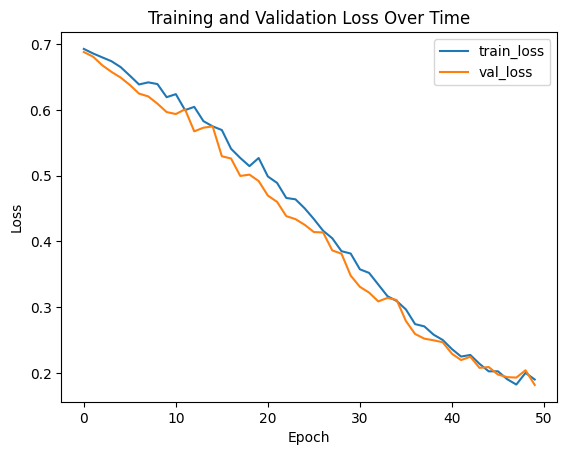

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [13]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    print("Classification Report:\n----------------------\n", clr)

In [14]:
import cv2
from scipy import ndimage as ndi

# Define the Gabor filter parameters
ksize = 9  # kernel size
sigma = 0.5  # Standard deviation of the Gaussian function
theta = np.pi / 4  # Orientation of the Gabor filter
lamda = np.pi / 2  # Wavelength of the sinusoidal factor
gamma = 0.5  # Spatial aspect ratio

In [15]:
# Create the Gabor filter kernel
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)

In [16]:
def apply_gabor_filter(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply the Gabor filter kernel to the image
    filtered = ndi.convolve(gray, kernel, mode='wrap')
    return filtered.reshape(image.shape)

In [17]:
# Modify the data generator to apply Gabor filter to the images
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=apply_gabor_filter
)

In [18]:
val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 140 validated image filenames belonging to 2 classes.


In [19]:
test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 300 validated image filenames belonging to 2 classes.
